<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Load-the-data" data-toc-modified-id="1.-Load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Load the data</a></span></li><li><span><a href="#2.-Filtering-out-the-noise" data-toc-modified-id="2.-Filtering-out-the-noise-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Filtering out the noise</a></span></li><li><span><a href="#3.-Even-better-filtering" data-toc-modified-id="3.-Even-better-filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Even better filtering</a></span></li><li><span><a href="#4.-Term-frequency-times-inverse-document-frequency" data-toc-modified-id="4.-Term-frequency-times-inverse-document-frequency-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Term frequency times inverse document frequency</a></span></li><li><span><a href="#5.-Utility-function" data-toc-modified-id="5.-Utility-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. Utility function</a></span></li></ul></div>

This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Text data pre-processing</div>

In this exercice, we shall load a database of email messages and pre-format them so that we can design automated classification methods or use off-the-shelf classifiers.

"What is there to pre-process?" you might ask. Well, actually, text data comes in a very noisy form that we, humans, have become accustomed to and filter out effortlessly to grasp the core meaning of the text. It has a lot of formatting (fonts, colors, typography...), punctuation, abbreviations, common words, grammatical rules, etc. that we might wish to discard before even starting the data analysis.

Here are some pre-processing steps that can be performed on text:
1. loading the data, removing attachements, merging title and body;
2. tokenizing - splitting the text into atomic "words";
3. removal of stop-words - very common words;
4. removal of non-words - punctuation, numbers, gibberish;
3. lemmatization - merge together "find", "finds", "finder".

The final goal is to be able to represent a document as a mathematical object, e.g. a vector, that our machine learning black boxes can process.

# 1. Text classification in English

## 1.1 Load the data

Let's first load the emails.

In [5]:
import os
data_switch=1
if(data_switch==0):
    train_dir = '../data/ling-spam/train-mails/'
    email_path = [os.path.join(train_dir,f) for f in os.listdir(train_dir)]
else:
    train_dir = '../data/lingspam_public/bare/'
    email_path = []
    email_label = []
    for d in os.listdir(train_dir):
        folder = os.path.join(train_dir,d)
        email_path += [os.path.join(folder,f) for f in os.listdir(folder)]
        email_label += [f[0:3]=='spm' for f in os.listdir(folder)]
print("number of emails",len(email_path))
email_nb = 8 # try 8 for a spam example
print("email file:", email_path[email_nb])
print("email is a spam:", email_label[email_nb])
print(open(email_path[email_nb]).read())

number of emails 2893
email file: ../data/lingspam_public/bare/part1\3-378msg5.txt
email is a spam: False
Subject: t

hi , help ! i have to design an experiment to do with mandarin tones as part of a phonology requirement on my graduate course . there seems to be very little literature on this in the library . if anyone can think of any on-going debates on the phonology / phonetics of mandarin tones for which an experiment would be useful , please could you give me information and references . i would welcome any suggestions at all . thanks a lot , sophia wang . ( sophia @ ling . ed . ac . uk )



## 1.2. Filtering out the noise

One nice thing about scikit-learn is that is has lots of preprocessing utilities. Like [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for instance, that converts a collection of text documents to a matrix of token counts.

- To remove stop-words, we set: `stop_words='english'`
- To convert all words to lowercase: `lowercase=True`
- The default tokenizer in scikit-learn removes punctuation and only keeps words of more than 2 letters.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer(input='filename', stop_words='english', lowercase=True)
word_count = countvect.fit_transform(email_path)

In [7]:
print("Number of documents:", len(email_path))
words = countvect.get_feature_names()
print("Number of words:", len(words))
print("Document - words matrix:", word_count.shape)
print("First words:", words[0:100])

Number of documents: 2893
Number of words: 60618
Document - words matrix: (2893, 60618)
First words: ['00', '000', '0000', '00001', '00003000140', '00003003958', '00007', '0001', '00010', '00014', '0003', '00036', '000bp', '000s', '000yen', '001', '0010', '0010010034', '0011', '00133', '0014', '00170', '0019', '00198', '002', '002656', '0027', '003', '0030', '0031', '00333', '0037', '0039', '003n7', '004', '0041', '0044', '0049', '005', '0057', '006', '0067', '007', '00710', '0073', '0074', '00799', '008', '009', '00919680', '0094', '00a', '00am', '00arrival', '00b', '00coffee', '00congress', '00d', '00dinner', '00f', '00h', '00hfstahlke', '00i', '00j', '00l', '00m', '00p', '00pm', '00r', '00t', '00tea', '00the', '00uzheb', '01', '0100', '01003', '01006', '0104', '0106', '01075', '0108', '011', '0111', '0117', '0118', '01202', '01222', '01223', '01225', '01232', '01235', '01273', '013', '0131', '01334', '0135', '01364', '0139', '013953', '013a']


## 1.3. Even better filtering

That's already quite ok, but this pre-processing does not perform lemmatization, the list of stop-words could be better and we could wish to remove non-english words (misspelled, with numbers, etc.).

A slightly better preprocessing uses the [Natural Language Toolkit](https://www.nltk.org/https://www.nltk.org/). The one below:
- tokenizes;
- removes punctuation;
- removes stop-words;
- removes non-English and misspelled words (optional);
- removes 1-character words;
- removes non-alphabetical words (numbers and codes essentially).

In [8]:
import nltk
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\DURANTGA\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DURANTGA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from nltk import wordpunct_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import words
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

class LemmaTokenizer(object):
    def __init__(self, remove_non_words=True):
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))
        self.words = set(words.words())
        self.remove_non_words = remove_non_words
    def __call__(self, doc):
        # tokenize words and punctuation
        word_list = wordpunct_tokenize(doc)
        # remove stopwords
        word_list = [word for word in word_list if word not in self.stopwords]
        # remove non words
        if(self.remove_non_words):
            word_list = [word for word in word_list if word in self.words]
        # remove 1-character words
        word_list = [word for word in word_list if len(word)>1]
        # remove non alpha
        word_list = [word for word in word_list if word.isalpha()]
        return [self.wnl.lemmatize(t) for t in word_list]



The LemmaTokenizer defined above will be applied further in this example. The next step is to define the Count Vectorization pipeline using this Tokenizer.

In [10]:
countvect = CountVectorizer(input='filename',tokenizer=LemmaTokenizer(remove_non_words=True))
bow = countvect.fit_transform(email_path)
feat2word = {v: k for k, v in countvect.vocabulary_.items()}

In [11]:
print("Number of documents:", len(email_path))
words = countvect.get_feature_names()
print("Number of words:", len(words))
print("Document - words matrix:", bow.shape)
print("First words:", words[0:100])

Number of documents: 2893
Number of words: 14279
Document - words matrix: (2893, 14279)
First words: ['aa', 'aal', 'aba', 'aback', 'abacus', 'abandon', 'abandoned', 'abandonment', 'abbas', 'abbreviation', 'abdomen', 'abduction', 'abed', 'aberrant', 'aberration', 'abide', 'abiding', 'abigail', 'ability', 'ablative', 'ablaut', 'able', 'abler', 'aboard', 'abolition', 'abord', 'aboriginal', 'aborigine', 'abound', 'abox', 'abreast', 'abridged', 'abroad', 'abrogate', 'abrook', 'abruptly', 'abscissa', 'absence', 'absent', 'absolute', 'absolutely', 'absoluteness', 'absolutist', 'absolutive', 'absolutization', 'absorbed', 'absorption', 'abstract', 'abstraction', 'abstractly', 'abstractness', 'absurd', 'absurdity', 'abu', 'abundance', 'abundant', 'abuse', 'abusive', 'abyss', 'academe', 'academic', 'academically', 'academician', 'academy', 'accelerate', 'accelerated', 'accelerative', 'accent', 'accentuate', 'accentuation', 'accept', 'acceptability', 'acceptable', 'acceptance', 'acceptation', 'acc

## 1.4. Using the bag of words (BOW) object to classify spam

Let's start by splitting the data into train and test sets, using 20% of the data for testing

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bow,email_label,test_size=0.2)

In this simple example we will use a Logistic Regression Classifier. Let's fit it to our Training Data

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr_classifier=LogisticRegression()
lr_classifier.fit(X_train,y_train)

y_predicted = lr_classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted))
print("Precision :",metrics.precision_score(y_test,y_predicted))
print("Recall :",metrics.recall_score(y_test,y_predicted))

c:\users\durantga\appdata\local\continuum\anaconda3\envs\courssup\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy : 0.9930915371329879
Precision : 0.9891304347826086
Recall : 0.9680851063829787


In many cases, Bag of Words can provide sufficient information for classification. In this case, the accuracy reached by our classifier is pretty good.

## 1.5. Term frequency times inverse document frequency

After this first preprocessing, each document is summarized by a vector of size "number of words in the extracted dictionnary". For example, the first email in the list has become:

In [14]:
mail_number = 0
text = open(email_path[mail_number]).read()
print("Original email:")
print(text)
#print(LemmaTokenizer()(text))
#print(len(set(LemmaTokenizer()(text))))
#print(len([feat2word[i] for i in word_count2[mail_number, :].nonzero()[1]]))
#print(len([word_count2[mail_number, i] for i in word_count2[mail_number, :].nonzero()[1]]))
#print(set([feat2word[i] for i in word_count2[mail_number, :].nonzero()[1]])-set(LemmaTokenizer()(text)))
emailBagOfWords = {feat2word[i]: word_count[mail_number, i] for i in word_count[mail_number, :].nonzero()[1]}
print("Bag of words representation (", len(emailBagOfWords), " words in dict):", sep='')
print(emailBagOfWords)
print("\nVector reprensentation (", word_count[mail_number, :].nonzero()[1].shape[0], " non-zero elements):", sep='')
print(word_count[mail_number, :])

Original email:
Subject: re : 2 . 882 s - > np np

> date : sun , 15 dec 91 02 : 25 : 02 est > from : michael < mmorse @ vm1 . yorku . ca > > subject : re : 2 . 864 queries > > wlodek zadrozny asks if there is " anything interesting " to be said > about the construction " s > np np " . . . second , > and very much related : might we consider the construction to be a form > of what has been discussed on this list of late as reduplication ? the > logical sense of " john mcnamara the name " is tautologous and thus , at > that level , indistinguishable from " well , well now , what have we here ? " . to say that ' john mcnamara the name ' is tautologous is to give support to those who say that a logic-based semantics is irrelevant to natural language . in what sense is it tautologous ? it supplies the value of an attribute followed by the attribute of which it is the value . if in fact the value of the name-attribute for the relevant entity were ' chaim shmendrik ' , ' john mcnamara the na

KeyError: 52566

Counting words is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called `tf` for Term Frequencies.

Another refinement on top of `tf` is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called `tf–idf` for “Term Frequency times Inverse Document Frequency” and again, scikit-learn does the job for us with the [TfidfTransformer](scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) function.

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit_transform(bow)
tfidf.shape

(2893, 14279)

Let's run the classification process again

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf,email_label,test_size=0.2)

#Fitting classifier
lr_classifier.fit(X_train,y_train)

#Testing classifier
y_predicted = lr_classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted))
print("Precision :",metrics.precision_score(y_test,y_predicted))
print("Recall :",metrics.recall_score(y_test,y_predicted))

Accuracy : 0.9706390328151986
Precision : 1.0
Recall : 0.83


In this simplae case, additional filtering is unecessary and even removed some information. There is indeed likely a link between the abundance of words/long emails and the fact that this email is a spam.

# 2. Text classification in French

The previously used dataset is a widely used dataset for introductory text classification. 

The field of Natural Language Understanding, and Natural Language Classification in particular, suffers from two challenges :
- Adapting the features and methodologies to various and more complex datasets
- Adapting the process to languages other than english

Concerning the latter, one has to take into account that most of NLU research is currently performed on english. Datasets are rarely available for other languages, and the algorithms proposed for better NLU are often left untested on foreign data. 
French, for instance, has less efficient lemmatization (french is a richly flected language). In the following section, we will reuse the same methodologies on a french dataset.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

#load video games reviews
vgr = pd.read_csv("datasets/jvc.csv")
vgr.head()

,Unnamed: 0,game_fr,game_en,platform,website_rating,public_rating,publishor/developer,release,type,classification,url,description
0,1,.hack//G.U. Last Recode,.hack//G.U. Last Recode,PS4,14/20,--/20,Bandai Namco Entertainment,03 Novembre 2017,RPG,+12 ans,http://www.jeuxvideo.com/jeux/ps4/jeu-674262/,"Au contraire d’autres titres, None ,''.hack'' ..."
1,2,.hack//G.U. Vol.1//Rebirth,.hack//G.U. Vol. 1//Rebirth,PS2,15/20,18.2/20,Bandai Namco CyberConnect2,Date de sortie inconnue,RPG,+7 ans,http://www.jeuxvideo.com/jeux/playstation-2-ps...,Avec plus de 20 œuvres de fiction sur de mult...
2,3,.hack//Infection Part 1,.hack//Infection: Part 1,PS2,15/20,15.1/20,CyberConnect2 Bandai,26 Mars 2004,RPG,+12 ans,http://www.jeuxvideo.com/jeux/playstation-2-ps...,S'appuyant sur la maxime « Mieux vaut tard qu...
3,4,.hack//Mutation Part 2,.hack//Mutation: Part 2,PS2,14/20,16.4/20,Bandai CyberConnect2,18 Juin 2004,RPG,+12 ans,http://www.jeuxvideo.com/jeux/playstation-2-ps...,Voici enfin le second volet de la quadrilogie...
4,5,.hack//Outbreak Part 3,.hack//Outbreak: Part 3,PS2,13/20,15.3/20,CyberConnect2 Atari,17 Septembre 2004,RPG,+12 ans,http://www.jeuxvideo.com/jeux/playstation-2-ps...,Comme la maxime «Jamais deux sans trois» ne c...


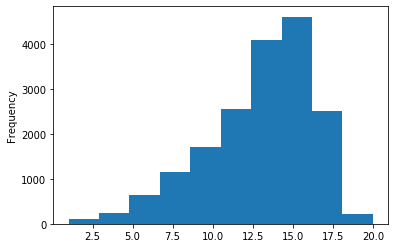

In [18]:
#convert rating to numeric values, and plot the histogram of values
rating=vgr.website_rating.apply(lambda k: k[:-3])
vgr['rating']=pd.to_numeric(rating)
vgr.rating.plot.hist()

Most games seem to have a rating between 11 and 16. In this exercise, we will try to determine if we can determine if a game is very good (rating above 16) or very bad (rating below 11) based only on the summary of its review.

Let's start by splitting the dataset between good and bad games

In [19]:
bad=vgr[(vgr.rating<=11) & (vgr.platform=="PC")]
bad['quality']=pd.Series(["bad"]*len(bad.index),index=bad.index)
good=vgr[(vgr.rating>=16) & (vgr.platform=="PC")]
good['quality']=pd.Series(["good"]*len(good.index),index=good.index)
selected_games=pd.concat([good,bad]).dropna()

#Keep only reviews and 
game_reviews=selected_games['description']
game_quality=selected_games['quality']


c:\users\durantga\appdata\local\continuum\anaconda3\envs\courssup\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\durantga\appdata\local\continuum\anaconda3\envs\courssup\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Lemmatization in French is a tricky issue.

One example : the verb finir can be expressed as finissons, finirez, finisse, finit, etc...
Lemmatization is typically less efficient in french than in english. 

Another alternative is to use Stemming instead. Stemming uses RegEx rules to truncate the end of a word that would normally correspond to conjugations, inflections, etc...
Stemming destructs the readability of the words by truncating their end, but runs faster than Lemmatization

In the next cell, we adapt the LemmaTokenizer that we defined earlier using a FrenchStemmer instead. 

In [21]:
from nltk.stem.snowball import FrenchStemmer
from nltk import wordpunct_tokenize          
from nltk.corpus import stopwords
from nltk.corpus import words
from string import punctuation
class FrenchStemTokenizer(object):
    def __init__(self, remove_non_words=True):
        self.st = FrenchStemmer()
        self.stopwords = set(stopwords.words('french'))
        self.words = set(words.words())
        self.remove_non_words = remove_non_words
    def __call__(self, doc):
        # tokenize words and punctuation
        word_list = wordpunct_tokenize(doc)
        # remove stopwords
        word_list = [word for word in word_list if word not in self.stopwords]
        # remove non words
        if(self.remove_non_words):
            word_list = [word for word in word_list if word in self.words]
        # remove 1-character words
        word_list = [word for word in word_list if len(word)>1]
        # remove non alpha
        word_list = [word for word in word_list if word.isalpha()]
        return [self.st.stem(t) for t in word_list]

countvect = CountVectorizer(tokenizer=FrenchStemTokenizer(remove_non_words=True))
bow_games = countvect.fit_transform(game_reviews)
feat2word = {v: k for k, v in countvect.vocabulary_.items()}

In [22]:
print("Number of documents:", len(game_reviews))
words = countvect.get_feature_names()
print("Number of words:", len(words))
print("Document - words matrix:", bow_games.shape)
print("First words:", words[0:100])

Number of documents: 2349
Number of words: 3161
Document - words matrix: (2349, 3161)
First words: ['abandon', 'abomin', 'abord', 'abras', 'absenc', 'absolut', 'absorb', 'abstract', 'abyssal', 'academy', 'accent', 'accept', 'access', 'accessibl', 'acclaim', 'accord', 'accouch', 'accru', 'accus', 'ace', 'aci', 'acolyt', 'acquisit', 'acquit', 'acquitt', 'act', 'action', 'activ', 'activity', 'actual', 'ad', 'adag', 'adapt', 'add', 'addict', 'addit', 'adieu', 'adieux', 'admir', 'adolescent', 'adopt', 'ador', 'adrenalin', 'adroit', 'advanc', 'advanced', 'adventur', 'advers', 'aero', 'affect', 'affili', 'affirm', 'affluenc', 'afflux', 'affront', 'afraid', 'after', 'afterbirth', 'against', 'age', 'agend', 'agent', 'aggress', 'agit', 'agon', 'agricol', 'agricultur', 'ah', 'aid', 'aiguill', 'aim', 'aion', 'air', 'al', 'alan', 'album', 'alfa', 'ali', 'alien', 'align', 'aliment', 'aliv', 'all', 'allan', 'allemand', 'aller', 'allianc', 'allur', 'allus', 'almost', 'alon', 'alpha', 'alphabet', 'alte

In [56]:
X_train, X_test, y_train, y_test = train_test_split(bow_games,game_quality,test_size=0.2)

#Fitting classifier
lr_classifier.fit(X_train,y_train)

#Testing classifier
y_predicted = lr_classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted))
print("Precision :",metrics.precision_score(y_test,y_predicted,pos_label="good"))
print("Recall :",metrics.recall_score(y_test,y_predicted,pos_label="good"))

Accuracy : 0.6808510638297872
Precision : 0.7008547008547008
Recall : 0.6721311475409836


In [60]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_games = TfidfTransformer().fit_transform(bow_games)
tfidf_games.shape

(2349, 3161)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_games,game_quality,test_size=0.2)

#Fitting classifier
lr_classifier.fit(X_train,y_train)

#Testing classifier
y_predicted = lr_classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,y_predicted))
print("Precision :",metrics.precision_score(y_test,y_predicted,pos_label="good"))
print("Recall :",metrics.recall_score(y_test,y_predicted,pos_label="good"))

Accuracy : 0.6510638297872341
Precision : 0.6382978723404256
Recall : 0.743801652892562


## Word2Vec

In [34]:
class FrenchTokenizer(object):
    def __init__(self):
        self.wnl = FrenchStemmer()
        self.stopwords = set(stopwords.words('french'))
        self.words = set(words.words())
    def __call__(self, doc):
        # tokenize words and punctuation
        word_list = wordpunct_tokenize(doc)
        # remove 1-character words
        word_list = [word for word in word_list if len(word)>1]
        # remove non alpha
        word_list = [word for word in word_list if word.isalpha()]
        return [self.wnl.stem(t) for t in word_list]

tok=FrenchTokenizer()

text_for_word2vec=[tok(sent) for sent in vgr['description'].dropna()]

In [45]:
from gensim.models import Word2Vec

model=Word2Vec(text_for_word2vec,size=200,window=5,min_count=1)
model.save("word2vec.model")
w2v=dict(zip(model.wv.index2word, model.wv.vectors))

In [36]:
model.wv.most_similar(positive="mal")

[('oubli', 0.7170845866203308),
 ('nécessair', 0.7137531042098999),
 ('facil', 0.7080598473548889),
 ('intérêt', 0.7036499977111816),
 ('toutefois', 0.703342854976654),
 ('potentiel', 0.701346755027771),
 ('sensat', 0.6931085586547852),
 ('besoin', 0.6889208555221558),
 ('boulot', 0.6879130005836487),
 ('sérieux', 0.6796602010726929)]

In [1]:
class MeanEmbeddingVectorizer(object):
    def __init__(self,word2vec,dim):
        self.word2vec=word2vec
        self.dim=dim
        
    def fit(self,X,y):
        return self
    
    def transform(self,X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [38]:
from sklearn.pipeline import Pipeline
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(game_reviews,game_quality,test_size=0.2)

pipe=Pipeline([('vectorizer',MeanEmbeddingVectorizer(w2v,200)),('classifier',lr_classifier)])

pipe.fit(X_train,y_train)

c:\users\durantga\appdata\local\continuum\anaconda3\envs\courssup\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 <__main__.MeanEmbeddingVectorizer object at 0x0000025193670E10>),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [39]:
predicted = pipe.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test,predicted))
print("Precision :",metrics.precision_score(y_test,predicted,pos_label="good"))
print("Recall :",metrics.recall_score(y_test,predicted,pos_label="good"))

Accuracy : 0.548936170212766
Precision : 0.5566502463054187
Recall : 0.875968992248062


What we observe here is that word2vec embeddings perform worse than what we learned from BOW or TFIDF. 

In our case, the training corpus for the embeddings was not large enough to ensure proper convergence and representation of the words.

It is also common that for smaller corpora (<10.000 docs approximately), TFIDF usually performs better for classification, whereas Word2Vec produces better results with larger corpora and across domains (e.g. training on data from Wikipedia, and then using the vectors on data from another field)
